# Geospatial Data Processing Pipeline

## Table of Contents
1. [Setup and Imports](#setup)
2. [Apelos Processing](#apelos)
   - [KML to GeoJSON Conversion](#conversion)
   - [Data Cleaning](#cleaning)
3. [Neighborhood Survey](#survey)
   - [Neighborhood Filtering](#filtering)
   - [Map Visualization](#visualization)
   - [Data Export](#export)



## Setup and Imports <a name="setup"></a>


In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import geoprocess as geo
geo.__version__

'0.1.0'

## Apelos Processing <a name="apelos"></a>

### KML to GeoJSON Conversion <a name="conversion"></a>

In [2]:
path_apelos = "raw_data/Estado Novo - mapeamento dos apelos.kml"
apelos = geo.convert_kml_to_geojson(
    path_apelos,
    "pre-processed_data/apelos.geojson"
)

✅ Success! Converted 'raw_data/Estado Novo - mapeamento dos apelos.kml' to 'pre-processed_data/apelos.geojson'



### Data cleaning and exporting
 
In this step, we process the raw "apelos" data to clean up the text descriptions and extract any associated links. 
For each record, we:
1. Use `geo.get_first_url` to extract the first URL from the HTML description, storing it in a new 'Link' column.
2. Use `geo.get_clean_text` to remove HTML tags and links from the 'Description' field, leaving only the visible text.

After cleaning, we export the resulting GeoDataFrame to a new GeoJSON file for further analysis.

In [3]:
for idx, row in apelos.iterrows():
    link = geo.get_first_url(row['Description'])
    clean_desc = geo.get_clean_text(row['Description'])
    apelos.at[idx, 'Link'] = link
    apelos.at[idx, 'Description'] = clean_desc

# Export the processed GeoDataFrame to GeoJSON
geo.save_geojson_pretty(apelos, "processed_data/apelos_clean.geojson");

✅ Success! Saved pretty GeoJSON to 'processed_data/apelos_clean.geojson'


## Neighborhood Survey <a name="survey"></a>

### Data loading

In [4]:
# Reading the GeoJSON file with all the neighborhoods
gdf = gpd.read_file("DATA.RIO/Limite_de_Bairros.geojson")

# Check the coordinate reference system
print(gdf.crs)

EPSG:4326


### Extraction n Filtering

In [20]:
# Create a set to store the names of neighborhoods ("bairros") that contain at least one "apelo" point
bairros = set()

# For each point in the "apelos" GeoDataFrame
for point in apelos.geometry:
    # Iterate through each row (neighborhood) in the neighborhoods GeoDataFrame
    for idx, row in gdf.iterrows():
        # Check if the neighborhood geometry contains the current point
        if row['geometry'].contains(point):
            # If so, add the neighborhood name to the set and stop checking further neighborhoods for this point
            bairros.add(row['nome'])
            break

# Convert the set of neighborhood names to a list
bairros = list(bairros)

# Filter the neighborhoods GeoDataFrame to only those whose names are in the list of bairros containing apelos
filtro_bairros = gdf[gdf["nome"].isin(bairros)]

filtro_bairros["nome"]


48                    Bonsucesso
79     Imperial de São Cristóvão
88                  Santo Cristo
89                        Centro
94                  Engenho Novo
101                  Cidade Nova
104                     Maracanã
109                       Tijuca
122                     Botafogo
129                      Humaitá
Name: nome, dtype: object

### Map Visualization <a name="visualization"></a>

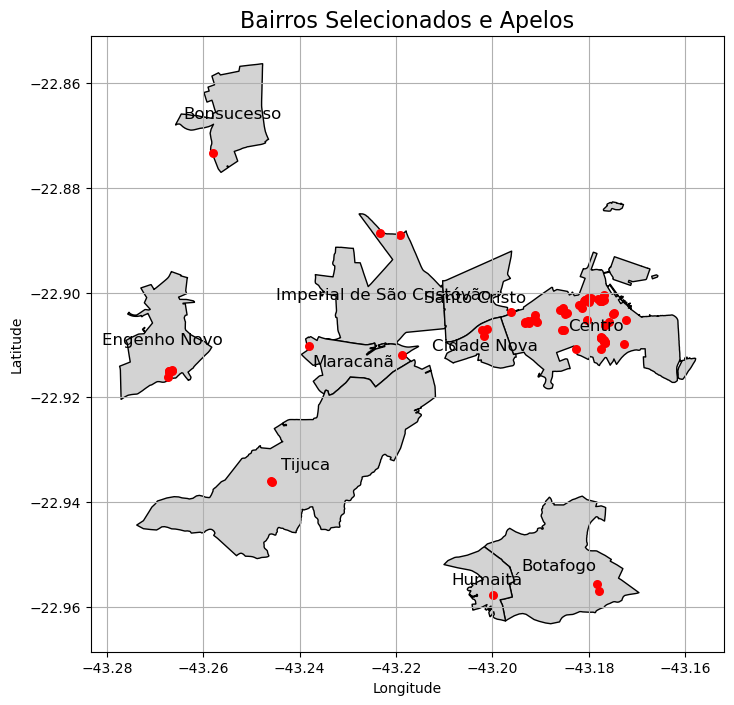

In [21]:
# Create a plot showing selected neighborhoods (filtro_bairros) and apelos
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot selected neighborhoods with a light gray color
filtro_bairros.plot(ax=ax, color='lightgray', edgecolor='black', legend=True)

# Get accurate centroids using the new function
centroids = geo.get_centroids(filtro_bairros)

# Add labels for each selected neighborhood
for label, x, y in zip(filtro_bairros.nome, centroids.x, centroids.y):
    ax.text(x, y, label, fontsize=12, ha='center', va='center')

# Plot apelos points
apelos.plot(ax=ax, color='red', markersize=30, marker='o', label='Apelos')

# Customize the plot
ax.set_title("Bairros Selecionados e Apelos", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)

### Data Export <a name="export"></a>

In [14]:
# Save the filtered data to a new GeoJSON file with pretty formatting
geo.save_geojson_pretty(filtro_bairros, "processed_data/filtro_bairros.geojson");

✅ Success! Saved pretty GeoJSON to 'processed_data/filtro_bairros.geojson'
